# 0.0. IMPORTS

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import sklearn.metrics   as m
import category_encoders as ce

import inflection
import pylab
import random
import warnings

from IPython.display         import Image
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split,  StratifiedKFold, GridSearchCV
from imblearn.over_sampling  import SMOTE
from boruta                  import BorutaPy
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.dummy           import DummyClassifier
from xgboost                 import XGBClassifier
from sklearn.metrics         import accuracy_score, classification_report



%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

## 0.1. Help Functions

In [3]:
#tamanho dos gráficos
def tamanho( x, y ):
    pylab.rcParams['figure.figsize'] = (x, y)

def ml_error( model_name, y, yhat ):
    print(model_name)
    print(classification_report(y_test, y_pred))
    
def ml_cv_results(model_name, model, x, y):
    
    
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
       
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        
        ## oversampling
        x_train_over, y_train_over = smote.fit_sample(x_train, y_train)
        
        ## training the model
        model.fit(x_train_over, y_train_over)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(m.balanced_accuracy_score(y_test, y_pred))
        precisions.append(m.precision_score(y_test, y_pred))
        recalls.append(m.recall_score(y_test, y_pred))
        f1s.append(m.f1_score(y_test, y_pred))
        
        
        
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std)},
                       index=[model_name])


## 0.2. Loading Data

In [4]:
df_raw = pd.read_csv('database/churn.csv')

# 1.0. DESCRIPTION OF DATA

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

snackecase = lambda x: inflection.underscore(x)
cols_new = list(map( snackecase, cols_old ) )

df1.columns = cols_new

## 1.3. Data Dimension 

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print('Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 10000
Number of Columns: 14


## 1.4. Data Type

In [8]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.5. Check NA e Duplicates

In [9]:
#Valores NA
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [10]:
#Numero de dados duplicados 
df1.duplicated().sum()

0

## 1.6. Descriptive Statistics

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

### 1.6.1. Numerical Attributes

In [12]:
## Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion, std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ) .T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.00,10000.00,9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,customer_id,15565701.00,15815690.00,249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,credit_score,350.00,850.00,500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,age,18.00,92.00,74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tenure,0.00,10.00,10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,balance,0.00,250898.09,250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,num_of_products,1.00,4.00,3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,has_cr_card,0.00,1.00,1.00,7.055000e-01,1.000000e+00,0.455818,-0.901812,-1.186973
8,is_active_member,0.00,1.00,1.00,5.151000e-01,1.000000e+00,0.499772,-0.060437,-1.996747
9,estimated_salary,11.58,199992.48,199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518


### 1.6.2. Categorical Attributes

In [13]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

surname      2932
geography       3
gender          2
dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

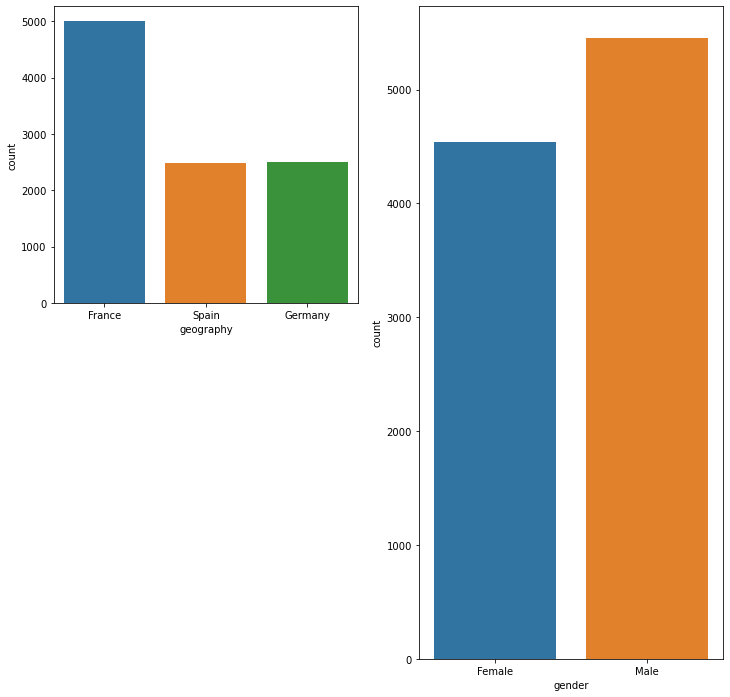

In [14]:
pylab.rcParams['figure.figsize'] = (12, 12)
plt.subplot( 2, 2, 1 )
sns.countplot( df1['geography'])

plt.subplot( 1, 2, 2 )
sns.countplot( df1['gender'])


# 2.0. FEATURE ENGINEERING 

In [15]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses 

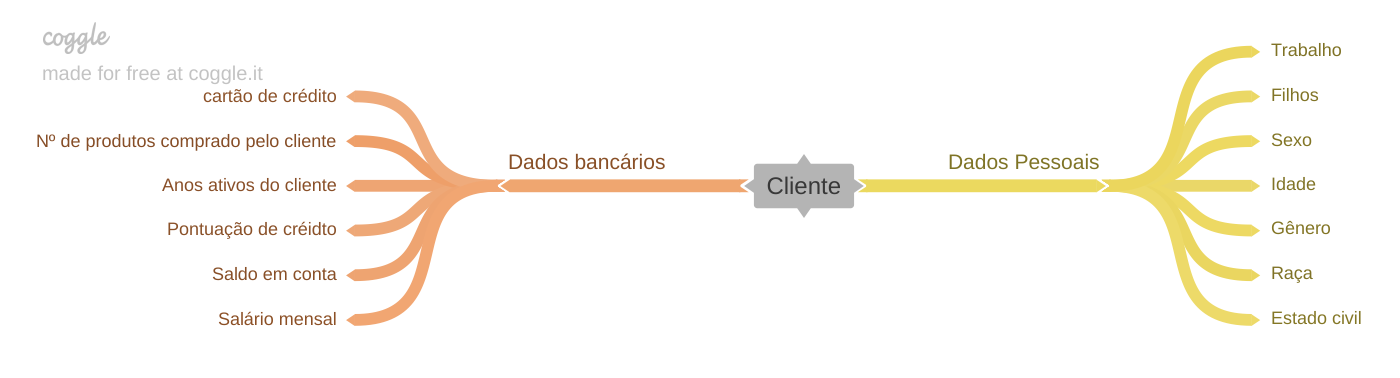

In [16]:
Image( 'img/cliente.png' )

## 2.2. Criação de Hipoteses

### 2.2.1. Dados Pessoais

**1.** Deveria haver mais churns entre os homens.

**2.** Clientes com mais idade deveriam ter mais churns.



### 2.2.2. Dados Bancarios 

**1.** Mulheres deveriam ter uma maior pontuação de crédito.

**2.** Quanto mais velho os clientes maior deveria ser a pontuação de crédito.

**3.** Homens deveriam tem um saldo em conta maior.

**4.** Clientes com o saldo maior deveriam ter menos churn.

**5.** Mulheres deveriam ter um número maior de compras de produtos realizadas.

**6.** Homens deveriam ter uma maior estimativa de salário mensal.

**7.** Clientes com a estimativa de salário mensal maior deveriam ter menos churn.

**8.** Quanto maior o tempo que o cliente permaneceu ativo maior é o seu saldo.


## 2.3. Lista Final de Hipoteses

**1.** Deveria haver mais churns entre os homens.

**2.** Clientes com mais idade deveriam ter mais churns.

**3.** Mulheres deveriam ter uma maior pontuação de crédito.

**4.** Quanto mais velho os clientes maior deveria ser a pontuação de crédito.

**5.** Homens deveriam tem um saldo em conta maior.

**6.** Clientes com o saldo maior deveriam ter menos churn.

**7.** Mulheres deveriam ter um número maior de compras de produtos realizadas.

**8.** Homens deveriam ter uma maior estimativa de salário mensal.

**9.** Clientes com a estimativa de salário mensal maior deveriam ter menos churn.

**10.** Quanto maior o tempo que o cliente permaneceu ativo maior é o seu saldo.

# 3.0. FILTRAAGEM DE VARIÁVEIS 

In [17]:
df3 = df2.copy()

## 3.1. Seleção das colunas 

In [18]:
#aqui vamos excluir as colunas que não são necessárias
df3 = df3.drop(['row_number', 'customer_id', 'surname'], axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS 

In [19]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

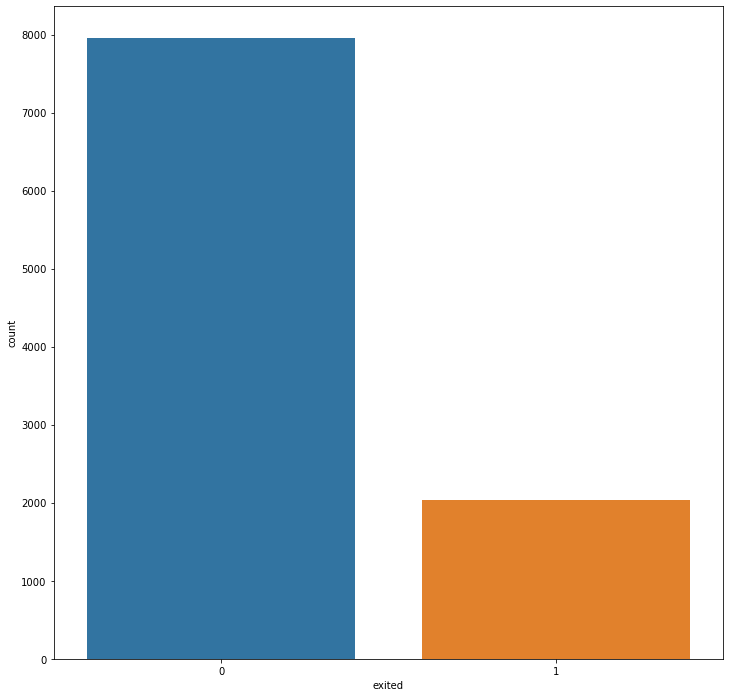

In [20]:
sns.countplot( x= 'exited', data=df4 );

### 4.1.2. Numerical Variable

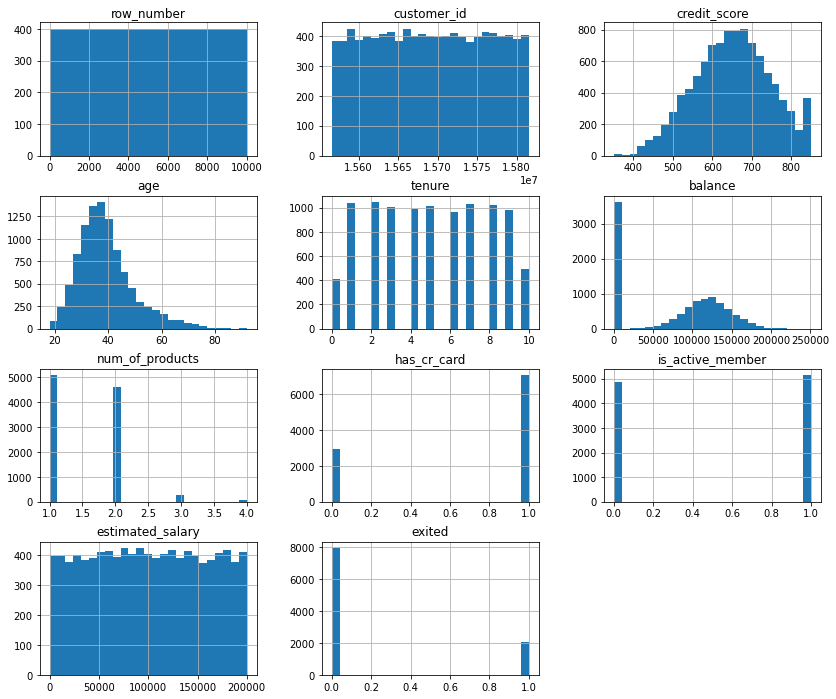

In [21]:
tamanho( 14, 12)
num_attributes.hist( bins=25);

### 4.1.3. Categorical Variable

In [22]:
cat_attributes.columns

Index(['surname', 'geography', 'gender'], dtype='object')

<AxesSubplot:xlabel='gender', ylabel='count'>

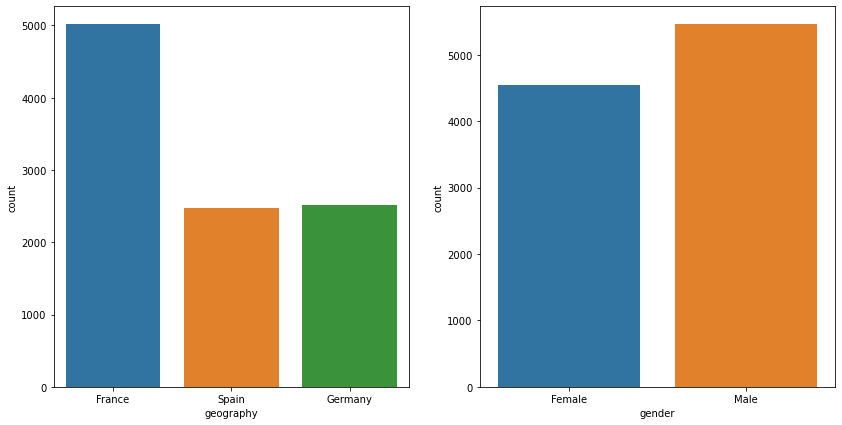

In [23]:
tamanho( 14, 7 )
plt.subplot( 1, 2, 1 )
sns.countplot( df4['geography'] )

plt.subplot( 1, 2, 2 )
sns.countplot( df4['gender'] )


## 4.2. Análise Bivariada

In [24]:
df4.head(1)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1


### H1. Deveria haver mais churns entre os homens.

**FALSO** A maioria dos churns são de clientes do sexo feminino. 

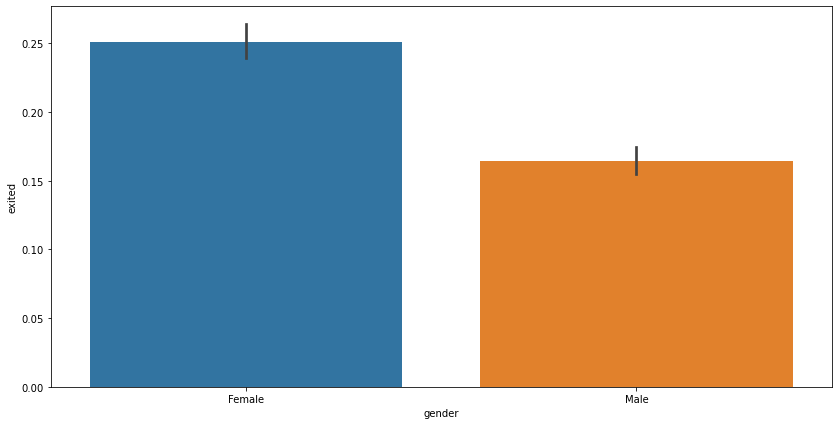

In [25]:
tamanho( 14, 7 )
sns.barplot( x='gender', y='exited', data=df4 );


### H2. Clientes com mais idade deveriam ter mais churns.

**FALSO** Os cliente que mais tem churn são os clientes com idade entre 36 e 54 anos.


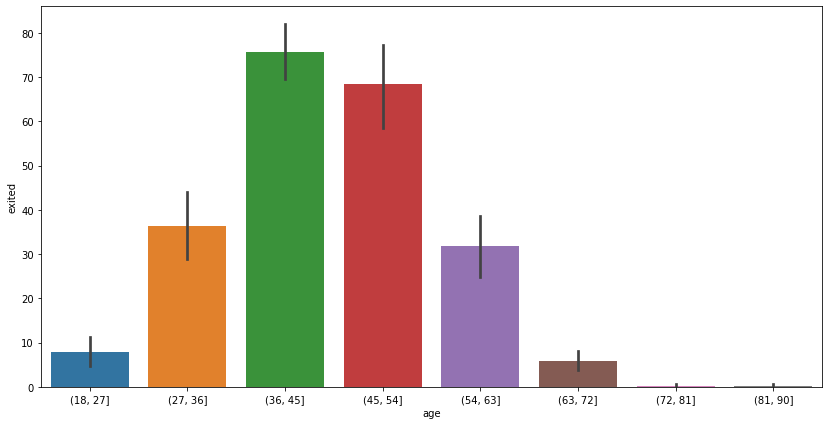

In [26]:
aux1 = df4[['age', 'exited']].groupby( 'age').sum().reset_index()
bins = list( np.arange( 18, 92, 9 ) )
aux1['age'] = pd.cut( aux1['age'], bins=bins )
sns.barplot( x='age', y='exited', data= aux1 );

### H3. Mulheres deveriam ter uma maior pontuação de crédito.

**INCONCLUSIVO** Não é possivel afirmar que mulheres tem maior pontuação de crédito.


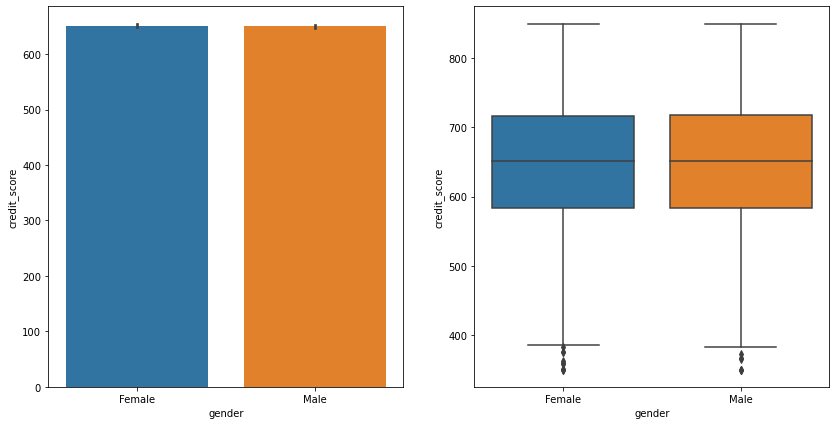

In [27]:
tamanho( 14, 7)
plt.subplot( 1, 2, 1 )
sns.barplot(x='gender', y='credit_score', data=df4 );

plt.subplot( 1, 2, 2 )
sns.boxplot(x='gender', y='credit_score', data=df4 );

### H4. Quanto mais velhos os clientes maior deveria ser a pontuação de crédito.

**FALSO** Os clientes que tem maior pontuação de crédito são os de 27 a 45.



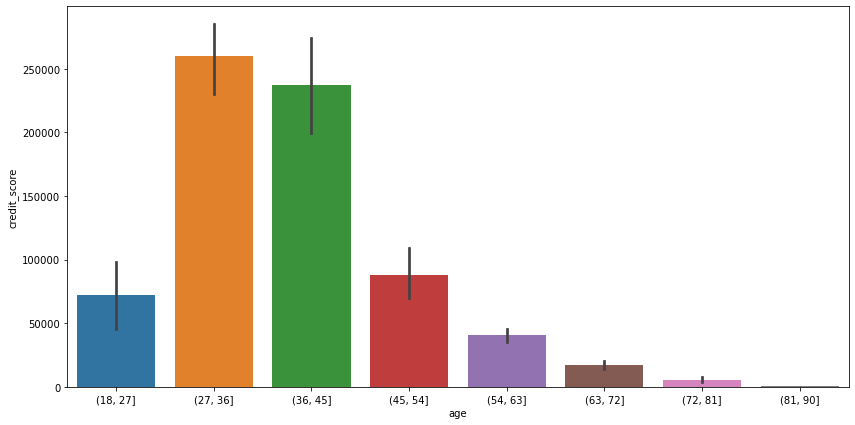

In [28]:
aux1 = df4[['age', 'credit_score']].groupby( 'age').sum().reset_index()
bins = list( np.arange( 18, 92, 9 ) )
aux1['age'] = pd.cut( aux1['age'], bins=bins )
sns.barplot( x='age', y='credit_score', data=aux1 );

### H5. Homens deveriam tem um saldo em conta maior.

**INCONCLUSIVO** Não pode ser dito se o homem tem um saldo maior em conta.



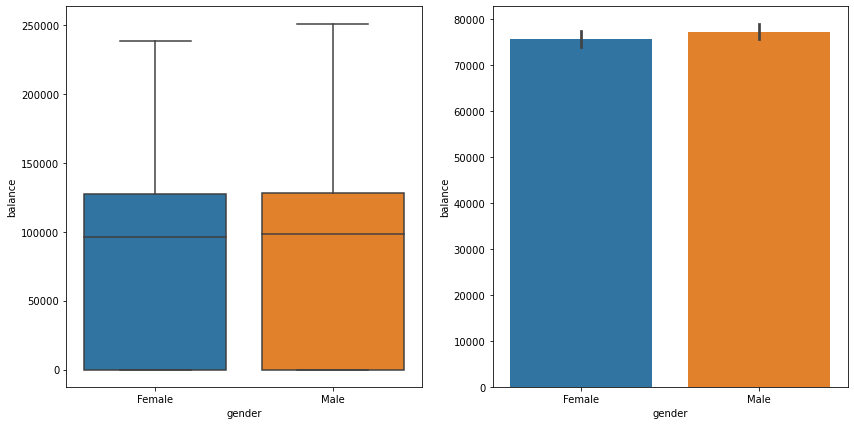

In [29]:
plt.subplot( 1, 2, 1 )
sns.boxplot( x='gender', y='balance', data=df4 )
plt.subplot( 1, 2, 2 )
sns.barplot( x='gender', y='balance', data=df4 );

### H6. Clientes com o saldo maior deveriam ter menos churn.


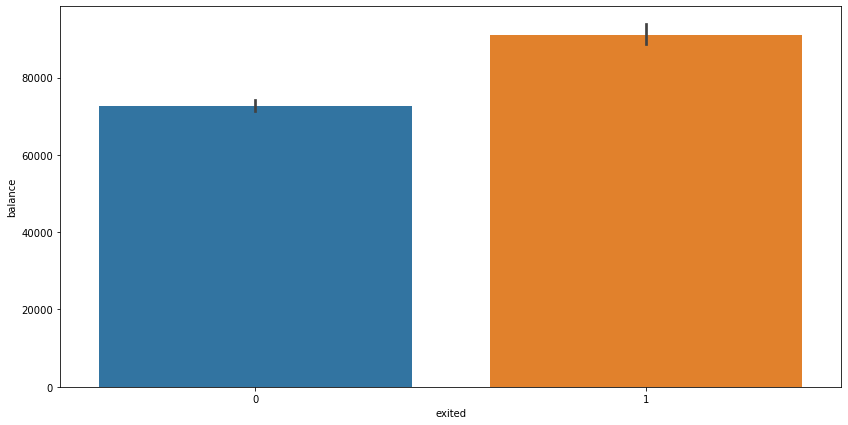

In [30]:
sns.barplot( x='exited', y='balance', data=df4);

### H7. Mulheres deveriam ter um número maior de compras de produtos realizadas.

**INCONCLUSIVO** Homens comprar mais os produtos 1 e 2 enquanto as mulheres comprar mais o produto 3 e 4.

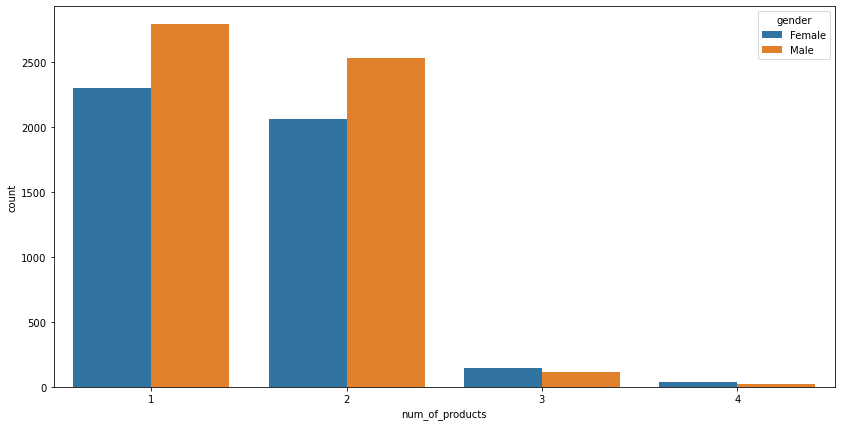

In [31]:
sns.countplot(x='num_of_products', hue= 'gender', data=df4);

### H8. Homens deveriam ter uma maior estimativa de salário mensal.

**INCONCLUSIVO** Não há diferença entre os clientes do sexo masculino e feminino.


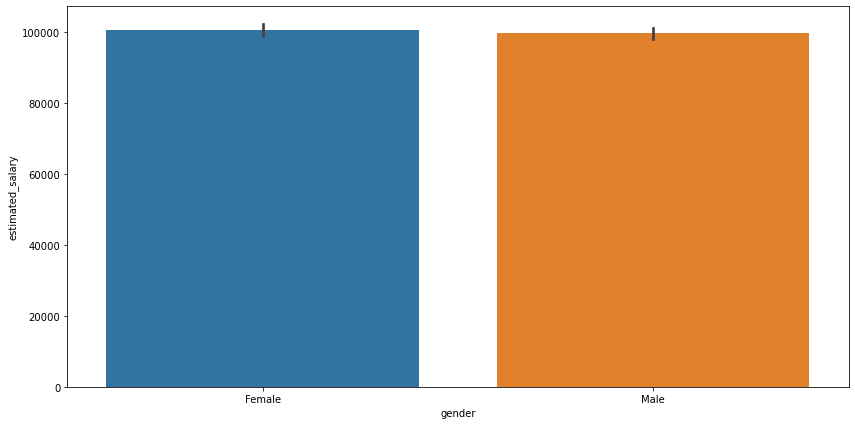

In [32]:
sns.barplot(x='gender', y='estimated_salary', data=df4);

### H9. Qunato maior o salário maior deveria ser o saldo .

<AxesSubplot:xlabel='estimated_salary', ylabel='balance'>

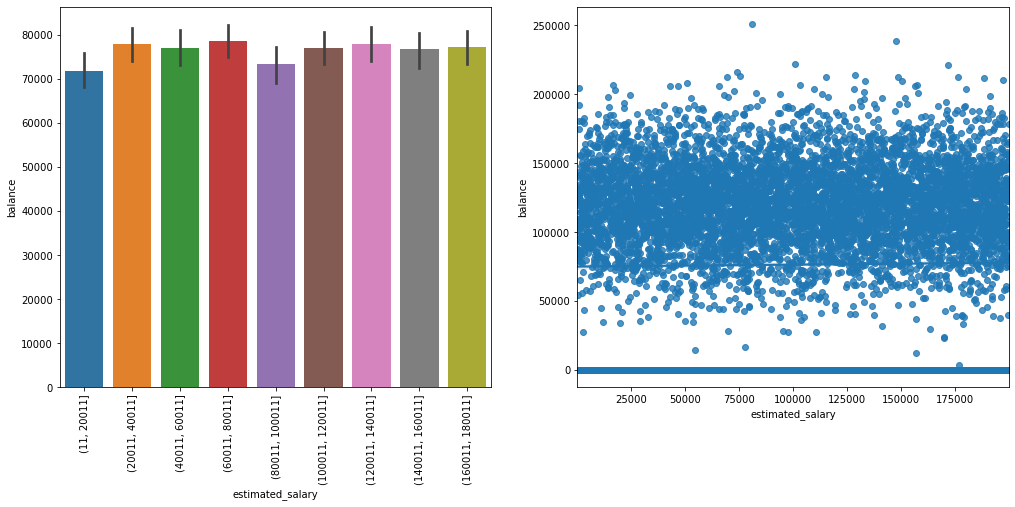

In [33]:
tamanho( 17, 7)
plt.subplot( 1, 2, 1 )
aux1 = df4[['balance', 'estimated_salary']].groupby( 'estimated_salary').sum().reset_index()
bins = list( np.arange( 11, 199992, 20000 ) )
aux1['estimated_salary'] = pd.cut( aux1['estimated_salary'], bins=bins )
sns.barplot( x='estimated_salary', y='balance', data=aux1 )
plt.xticks( rotation= 90 );

plt.subplot( 1, 2, 2 )
sns.regplot( x='estimated_salary', y='balance', data=df4)

### H10. Quanto maior o tempo que o cliente permaneceu ativo maior é o seu saldo.

**FALSO** Quanto maior o tempo que o cliente permanece ativo menor é o seu saldo.

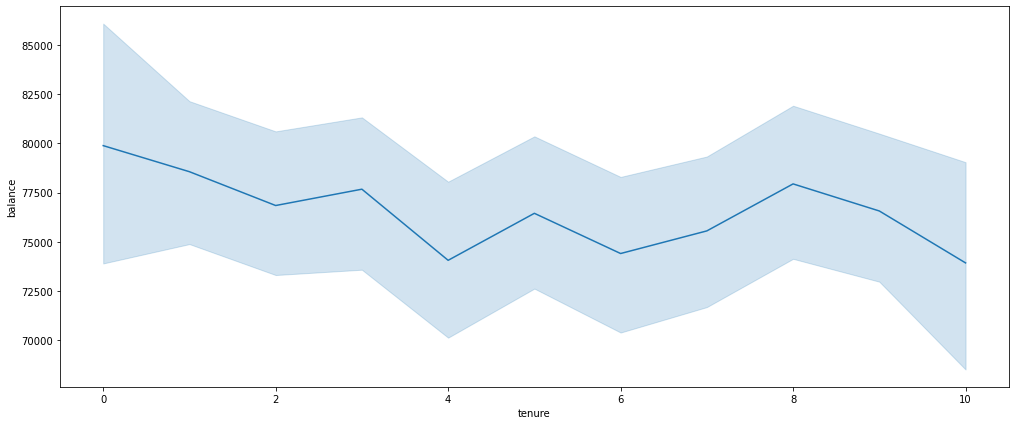

In [34]:
sns.lineplot(y='balance', x='tenure', data=df4);

## 4.3. Análise Multivariada

### Numerical Attributes

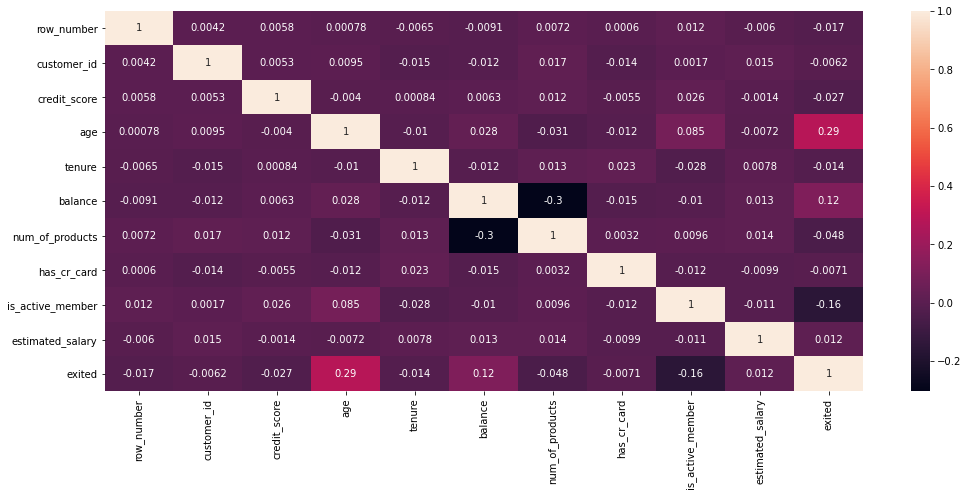

In [35]:
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot=True );

# 5.0. DATA PREPARATION

In [36]:
df5 = df4.copy()

## 5.1. Rescaling

In [37]:
mms = MinMaxScaler()

df5['credit_score'] = mms.fit_transform( df5[['credit_score']].values )

df5['age'] = mms.fit_transform( df5[['age']].values )

df5['tenure'] = mms.fit_transform( df5[['tenure']].values )

df5['balance'] = mms.fit_transform( df5[['balance']].values )

df5['num_of_products'] = mms.fit_transform( df5[['num_of_products']].values )

df5['has_cr_card'] = mms.fit_transform( df5[['has_cr_card']].values )

df5['is_active_member'] = mms.fit_transform( df5[['is_active_member']].values )

df5['estimated_salary'] = mms.fit_transform( df5[['estimated_salary']].values )

df5['has_cr_card'] = mms.fit_transform( df5[['has_cr_card']].values )

## 5.2. Transformação

### 5.2.1. Encoding

In [38]:
df5 = pd.get_dummies( df5, prefix=['geography'], columns=['geography'] )

df5 = pd.get_dummies( df5, prefix=['gender'], columns=['gender'] )


## 5.3. Balanceando a váriavél resposta

In [39]:
smote = SMOTE()
x, y = smote.fit_resample( df5, df5['exited'] )

In [40]:
x.drop('exited', axis=1, inplace=True)

In [41]:
df5 = pd.concat([x,y], axis=1 ).reset_index()

# 6.0. PASSO 06 - FEATURE SELECTION

In [42]:
df6 = df5.copy()

## 6.1. Split Dataframe into training and test dataset

In [43]:
X = df6.drop( columns=['exited', 'index'], axis=1 )
y = df5.exited

In [44]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size= 0.20 )

In [45]:
X_train_n = X_train.to_numpy()
y_train_n = y_train.values.ravel()

## 6.2. Boruta as Feature Selector

In [46]:
 #define Boruta
boruta = BorutaPy( RandomForestClassifier(class_weight='balanced'), n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )
boruta.fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	7
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentativ

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=50,
                                          random_state=RandomState(MT19937) at 0x1940FCDF540),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1940FCDF540, verbose=2)

### 6.2.1. Best Features from Boruta

In [47]:
cols_selected = boruta.support_.tolist()
#
## best features
X_train_fs = X_train
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [48]:
cols_selected_boruta

['credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'estimated_salary']

## 6.3. Manual Feature Selection

In [49]:
cols_selected_boruta = ['credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'estimated_salary']

#columns to add
feat_to_add = ['exited']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add)

# 7.0. MACHINE LEARNING MODELLING

In [50]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

## 7.1. Baseline mode

In [51]:
modelo = DummyClassifier()
modelo.fit( X_train, y_train )

DummyClassifier()

In [52]:
y_pred = modelo.predict( X_test)
print('acurácia',accuracy_score( y_test, y_pred )*100)
print(classification_report(y_test, y_pred))

acurácia 51.06716886377903
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1547
           1       0.52      0.52      0.52      1639

    accuracy                           0.51      3186
   macro avg       0.51      0.51      0.51      3186
weighted avg       0.51      0.51      0.51      3186



### 7.1.1. Cross Validation dummy

In [53]:
dummy_cv = ml_cv_results('dummy', DummyClassifier(), X_train, y_train)
dummy_cv


,Balanced Accuracy,Precision,Recall,F1
dummy,0.501 +/- 0.006,0.497 +/- 0.006,0.505 +/- 0.01,0.501 +/- 0.007


## 7.2. Random Forest Classifier

In [54]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print('accuracy_score',accuracy_score(y_test, y_pred)* 100)
print(classification_report(y_test, y_pred))

accuracy_score 88.95166352793471
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1547
           1       0.89      0.89      0.89      1639

    accuracy                           0.89      3186
   macro avg       0.89      0.89      0.89      3186
weighted avg       0.89      0.89      0.89      3186



### 7.2.1. Cross Validation Random Forest Classifier

In [55]:
rfc_cv = ml_cv_results('Random Forest Classifier', RandomForestClassifier(), x, y)
rfc_cv

,Balanced Accuracy,Precision,Recall,F1
Random Forest Classifier,0.898 +/- 0.006,0.894 +/- 0.008,0.902 +/- 0.004,0.898 +/- 0.005


## 7.3.  XGBoost 

In [56]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print('accuracy_score',accuracy_score(y_test, y_pred)* 100)
print(m.classification_report(y_test, y_pred))

[13:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy_score 90.42686754551161
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1547
           1       0.93      0.88      0.90      1639

    accuracy                           0.90      3186
   macro avg       0.90      0.90      0.90      3186
weighted avg       0.91      0.90      0.90      3186



### 7.3.1. Cross Validation XGBoost

In [57]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(random_state=42), x, y)
xgb_cv

[13:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Balanced Accuracy,Precision,Recall,F1
XGBoost,0.903 +/- 0.003,0.924 +/- 0.007,0.879 +/- 0.007,0.901 +/- 0.003


### 7.4. KNN Classifier

In [58]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('accuracy_score',accuracy_score(y_test, y_pred)* 100)
print(m.classification_report(y_test, y_pred))

accuracy_score 83.52165725047081
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1547
           1       0.79      0.93      0.85      1639

    accuracy                           0.84      3186
   macro avg       0.85      0.83      0.83      3186
weighted avg       0.85      0.84      0.83      3186



### 7.4.1.Cross Validation KNN

In [59]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), x, y)
knn_cv

,Balanced Accuracy,Precision,Recall,F1
K Nearest Neighbors,0.834 +/- 0.004,0.782 +/- 0.003,0.927 +/- 0.005,0.848 +/- 0.003


## 7.5. Compare Model's Performance

### 7.5.1. Cross Validation Performance

In [60]:
model_result_cv = pd.concat( [dummy_cv, rfc_cv, xgb_cv, knn_cv] )
model_result_cv

,Balanced Accuracy,Precision,Recall,F1
dummy,0.501 +/- 0.006,0.497 +/- 0.006,0.505 +/- 0.01,0.501 +/- 0.007
Random Forest Classifier,0.898 +/- 0.006,0.894 +/- 0.008,0.902 +/- 0.004,0.898 +/- 0.005
XGBoost,0.903 +/- 0.003,0.924 +/- 0.007,0.879 +/- 0.007,0.901 +/- 0.003
K Nearest Neighbors,0.834 +/- 0.004,0.782 +/- 0.003,0.927 +/- 0.005,0.848 +/- 0.003


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Grid Search

In [61]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

In [62]:
#CV_rfc = GridSearchCV(estimator=xgb, param_grid=param, cv= 5)
#CV_rfc.fit(x_train, y_train)

In [63]:
best_params = CV_rfc.best_params_
best_params

NameError: name 'CV_rfc' is not defined

## 8.2. Final Model

In [64]:
param_tuned = {'colsample_bytree': 0.3,
 'eta': 0.01,
 'max_depth': 3,
 'min_child_weight': 15,
 'n_estimators': 1700,
 'subsample': 0.5}

### 8.2.1.Result without cross-validation

In [65]:
xgb_tuned=XGBClassifier(colsample_bytree= 0.3, n_estimators= 1700, max_depth=3, eta=0.01, min_child_weight= 15, subsample= 0.5)

In [66]:
xgb_tuned.fit(x_train, y_train)

[14:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eta=0.01, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=3,
              min_child_weight=15, missing=nan, monotone_constraints='()',
              n_estimators=1700, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
pred=rfc1.predict(x_test)

NameError: name 'rfc1' is not defined

In [68]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,y_pred))

Accuracy for Random Forest on CV data:  0.835216572504708


### 8.2.2. Cross Validation

In [69]:
print(m.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1547
           1       0.79      0.93      0.85      1639

    accuracy                           0.84      3186
   macro avg       0.85      0.83      0.83      3186
weighted avg       0.85      0.84      0.83      3186



In [70]:
xgb_tuned_cv = ml_cv_results('XGBoost', xgb_tuned, x, y)
xgb_tuned_cv

[14:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Balanced Accuracy,Precision,Recall,F1
XGBoost,0.867 +/- 0.007,0.878 +/- 0.007,0.853 +/- 0.01,0.865 +/- 0.007


# 9.0. TRADUCAO E INTERPRETACAO DO ERRO

## 9.1. Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?

In [88]:
aux2 = df2['is_active_member'].value_counts().reset_index()

churn_year_rate = aux2[aux2['index'] == 1]['is_active_member'].sum() / aux2['is_active_member'].sum() * 100
churn_month_rate = churn_year_rate / 12

In [89]:
print('The monthly churn rate vary {:.2f}%.'.format(churn_month_rate))

The monthly churn rate vary 4.29%.
